In [2]:
import re
import time
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import init_notebook_mode, iplot

from tqdm import tqdm_notebook

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score, confusion_matrix

import nltk
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation

init_notebook_mode(connected=True)
%matplotlib inline
sns.set()
nltk.download("stopwords")
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /notebooks/home/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def to_vw_format(text, title=None, tags=None, numeric=None, label=None):
    """Transform our data to Vowpal Wabbit format"""

    result = str(label or '') + ' |text ' + \
        ' '.join(re.findall('\w{3,}', text.lower()))

    if title:
        result += ' |title ' + ' '.join(re.findall('\w{3,}', title.lower()))

    if tags:
        result += ' |tags ' + ' '.join(tags)

    if numeric is not None:
        result += ' |num ' + ' '.join(numeric)

    result += '\n'

    return result


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred) - 1]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(14, 12))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=topic_encoder.inverse_transform(classes - 1),
           yticklabels=topic_encoder.inverse_transform(classes - 1),
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


def preprocess_text(text):
    """Text preprocess function"""
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens
              if token not in russian_stopwords
              and token != " "
              and token.strip() not in punctuation]

    text = " ".join(tokens)

    return text

In [68]:
df = pd.read_csv('data/news_lenta.csv')

In [69]:
df.head()

,tags,text,title,topic,url
0,Общество,Миллиардер Илон Маск в резкой форме ответил бр...,Илон Маск назвал педофилом спасавшего детей из...,Мир,https://lenta.ru/news/2018/07/16/su57/
1,Рынки,США и их западные союзники рассматривают возмо...,США задумались о распечатывании нефтяного резерва,Экономика,https://lenta.ru/news/2018/07/16/foes/
2,Преступность,Празднование победы сборной Франции на чемпион...,Празднование победы на ЧМ во Франции закончило...,Мир,https://lenta.ru/news/2018/07/15/fra_bezumie/
3,Политика,География использования лимузинов проекта «Кор...,Песков рассказал о планах на президентские лим...,Россия,https://lenta.ru/news/2018/07/16/delo_shyut/
4,Музыка,Американская поп-певица Бритни Спирс случайно ...,Грудь Бритни Спирс вновь выскочила из лифчика ...,Культура,https://lenta.ru/news/2018/07/16/pedomusk/


In [70]:
df['topic'].nunique()

23

In [71]:
df['topic'].value_counts()

Россия               158072
Мир                  134334
Экономика             77673
Спорт                 62463
Культура              52600
Бывший СССР           52018
Наука и техника       51869
Интернет и СМИ        43313
Из жизни              26356
Силовые структуры     18480
Бизнес                 7398
Ценности               6832
Путешествия            6045
69-я параллель         1095
Крым                    666
Культпросвет            340
Легпром                 114
Библиотека               65
Дом                       6
Оружие                    3
ЧМ-2014                   2
Сочи                      1
МедНовости                1
Name: topic, dtype: int64

In [ ]:
plt.figure(figsize=(12, 8))
plt.bar(df['topic'].value_counts().index,
        df['topic'].value_counts())
plt.xticks(rotation='vertical')
plt.title('Distribution of news by topic')

Find missing values

In [73]:
df_null = pd.DataFrame(df.isnull().sum()[df.isnull().sum() > 0].
                       sort_values(ascending=False),
                       columns=['missing'])
df_null

,missing
tags,24049


Only the Tags feature has missing values, so fill them with the new NoTags value

In [74]:
df['tags'].fillna('NoTags', inplace=True)

In [75]:
df_null = pd.DataFrame(df.isnull().sum()[df.isnull().sum() > 0].
                       sort_values(ascending=False),
                       columns=['missing'])
df_null

,missing


In [76]:
df['tags'].value_counts()

Все                  440555
Политика              30910
Общество              25782
NoTags                24049
Украина               16892
Происшествия          14868
Футбол                12023
Госэкономика          11930
Кино                   8622
Бизнес                 7987
Интернет               7199
Наука                  6715
Следствие и суд        6162
Музыка                 5265
Люди                   4693
Преступность           4554
Космос                 3380
События                3061
Конфликты              2957
Coцсети                2811
Летние виды            2800
ТВ и радио             2713
Деловой климат         2434
Криминал               2362
Явления                2263
Регионы                2220
Гаджеты                2122
Мир                    2092
Бокс и ММА             2068
Игры                   2061
                      ...  
Еда                     430
Молдавия                423
Катастрофы              404
Вещи                    393
Реклама             

## Vowpal Wabbit Base model

Let's build a base model in where we will analyze only the text without preprocessing, without any additional features.

In [77]:
df_sample = df.copy()
df_sample.drop(columns=['tags', 'title', 'url'], inplace=True)
df_sample.head()

,text,topic
0,Миллиардер Илон Маск в резкой форме ответил бр...,Мир
1,США и их западные союзники рассматривают возмо...,Экономика
2,Празднование победы сборной Франции на чемпион...,Мир
3,География использования лимузинов проекта «Кор...,Россия
4,Американская поп-певица Бритни Спирс случайно ...,Культура


To build the model we will use the library Vowpal Wabbit. With the hashing trick implemented, Vowpal Wabbit is a perfect choice for working with text data. It is prominent for its training speed and support of many training modes, especially for online learning with big and high-dimentional data.



In [78]:
topic_encoder = LabelEncoder()
all_targets = topic_encoder.fit_transform(df_sample['topic']) + 1

In [79]:
np.unique(all_targets).shape

(23,)

We split our data into train and test and write these into separate files and convert the data into something Vowpal Wabbit can understand. We will throw away words shorter than 3 symbols.

In [80]:
train_news, test_news, train_targets, test_targets = \
    train_test_split(df_sample['text'], all_targets,
                     test_size=0.3, random_state=1)

Pass the created training file to Vowpal Wabbit. We solve the classification problem with a logistic loss function and without ngrams because it showed better result after trials with different args. Also we add a coefficient in front of class 1 because our classes are imbalanced.

In [83]:
with open('data/news/train.vw', 'w') as vw_train_data:
    for text, target in zip(train_news, train_targets):
        vw_train_data.write(to_vw_format(text, label=target))
        
with open('data/news/test.vw', 'w') as vw_test_data:
    for text in test_news:
        vw_test_data.write(to_vw_format(text))

In [84]:
!vw --oaa 23 -d data/news/train.vw \
--loss_function logistic \
-f data/news/train_model.vw

final_regressor = data/news/train_model.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = data/news/train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0       17        1       66
1.000000 1.000000            2            2.0       13       17      249
0.750000 0.500000            4            4.0       17       13      171
0.875000 1.000000            8            8.0       14       13      162
0.812500 0.750000           16           16.0       13       13      119
0.781250 0.750000           32           32.0        4       17      117
0.750000 0.718750           64           64.0       18       17      120
0.703125 0.656250          128          128.0       13       13      197
0.613281 0.523438          256          256.0       17       17       98
0.554688 0.49609

To calculate the loss function, VW uses examples not yet reviewed, that's why, as a rule, this estimation is correct. Let's apply the trained model on the test sample saving the predictions into the file

In [85]:
!vw -i data/news/train_model.vw -t \
-d data/news/test.vw \
-p data/news/test_predictions.txt --quiet

Since the classes are unbalanced, we will use micro-averaging to take into account the contribution of each class according to its size.

Since Precision equals Recall for micro-average, because False positive = False negative in one-versus-all classification, F-score = Precision = Recall, respectively. 
And even more, they are equal to Accuracy.

That's why we will use Accuracy as a metric, and we will print Confusion matrix in which classes the errors occur.

In [86]:
with open('data/news/test_predictions.txt') as pred_file:
    test_prediction = [float(label)
                       for label in pred_file.readlines()]

In [87]:
print('Accuracy: ' + str(round(accuracy_score(test_targets, 
                                              test_prediction), 3)))

Accuracy: 0.815


Normalized confusion matrix


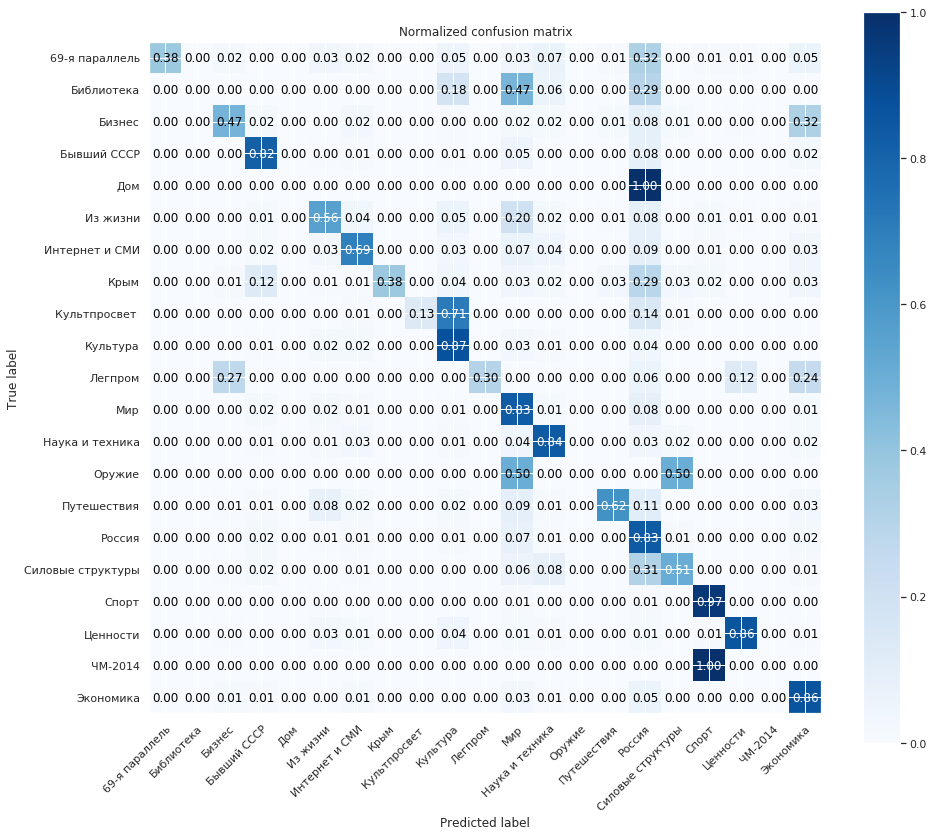

In [88]:
plot_confusion_matrix(test_targets, test_prediction, 
                      classes=np.arange(1, 24), normalize=True)

With Confusion matrix you can see where the classifier is most wrong. For example, all the news with the World Cup theme was included in the news with the topic Sport.

In [89]:
df_sample['topic'].value_counts()

Россия               158072
Мир                  134334
Экономика             77673
Спорт                 62463
Культура              52600
Бывший СССР           52018
Наука и техника       51869
Интернет и СМИ        43313
Из жизни              26356
Силовые структуры     18480
Бизнес                 7398
Ценности               6832
Путешествия            6045
69-я параллель         1095
Крым                    666
Культпросвет            340
Легпром                 114
Библиотека               65
Дом                       6
Оружие                    3
ЧМ-2014                   2
Сочи                      1
МедНовости                1
Name: topic, dtype: int64

## Vowpal Wabbit with text preprocessing

Let's try to improve our result by using lemmatization.

Create lemmatizer and stopwords list

In [90]:
mystem = Mystem()
russian_stopwords = stopwords.words("russian")

Let's comment on the following blocks so far to avoid running the code in them by accident

In [673]:
# %%time
# df['text'] = [preprocess_text(df['text'][i]) 
#               for i in tqdm_notebook(range(len(df['text'])))]

CPU times: user 47min 18s, sys: 3min 18s, total: 50min 37s
Wall time: 3h 1min 9s


In [674]:
# %%time
# df['title'] = [preprocess_text(df['title'][i]) 
#                for i in tqdm_notebook(range(len(df['title'])))]

CPU times: user 7min 5s, sys: 1min 31s, total: 8min 37s
Wall time: 19min 23s


Let's save the obtained data frame into a new file, because preprocessing takes a lot of time.

In [677]:
# df.to_csv('data/lemm_stopw_news_lenta.csv')

In [4]:
# df_preprocessed = pd.read_csv('data/lemm_stopw_news_lenta.csv', 
#                               index_col='Unnamed: 0')

In [92]:
df_sample = df_preprocessed.copy()

topic_encoder = LabelEncoder()
all_targets = topic_encoder.fit_transform(df_sample['topic']) + 1

In [93]:
train_news, test_news, train_targets, test_targets = \
    train_test_split(df_sample, all_targets, 
                     test_size=0.3, random_state=1)

In [94]:
with open('data/news/train.vw', 'w') as vw_train_data:
    for text, target in zip(train_news['text'], train_targets):
        vw_train_data.write(to_vw_format(text, label=target))
        
with open('data/news/test.vw', 'w') as vw_test_data:
    for text in test_news['text']:
        vw_test_data.write(to_vw_format(text))

In [95]:
!vw --oaa 23 -d data/news/train.vw \
--loss_function logistic \
-f data/news/train_model.vw --quiet

In [96]:
!vw -i data/news/train_model.vw -t \
-d data/news/test.vw \
-p data/news/test_predictions.txt --quiet

In [97]:
with open('data/news/test_predictions.txt') as pred_file:
    test_prediction = [float(label)
                       for label in pred_file.readlines()]

In [98]:
print('Accuracy: ' + str(round(accuracy_score(test_targets, 
                                              test_prediction), 3)))

Accuracy: 0.828


As we can see, the preprocessing of the text gave a slight improvement in quality.

Normalized confusion matrix


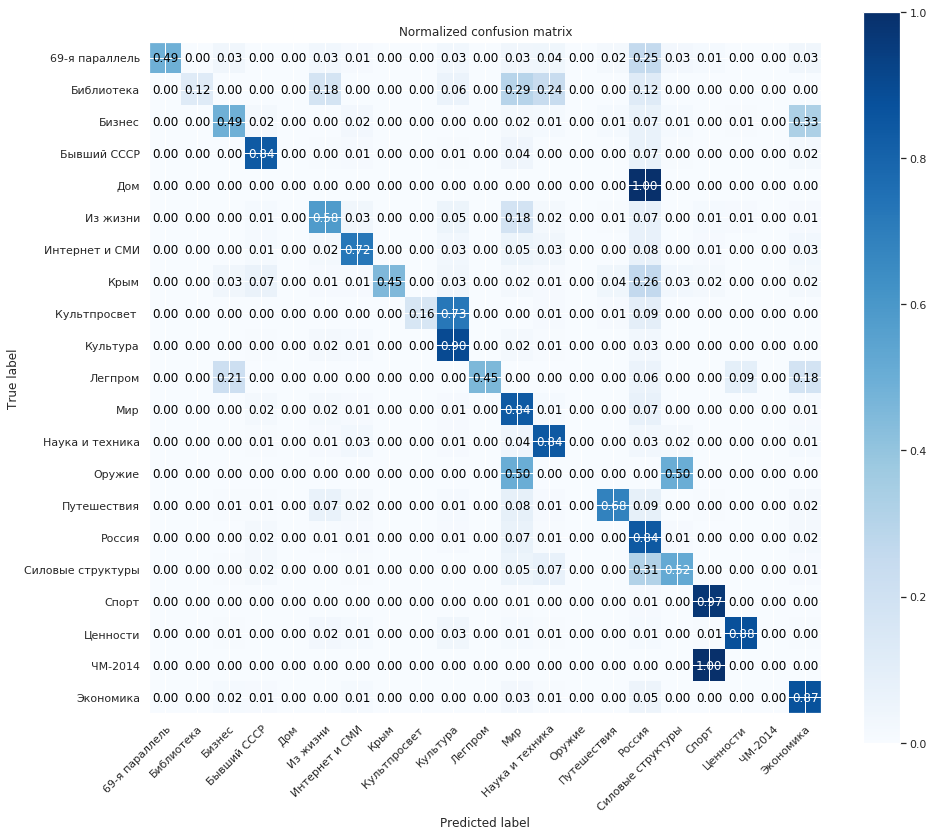

In [99]:
plot_confusion_matrix(test_targets, test_prediction, 
                      classes=np.arange(1, 24), normalize=True)

## Vowpal Wabbit with text preprocessing and tags distribution

There's probably some correlation between the tag and the news topic. We can try to use this information to improve quality. The rest of the features are not yet used to test our hypothesis.

In [100]:
df_sample = df_preprocessed.copy()

In [101]:
cmatrix = pd.crosstab(df_sample['tags'], 
                      df_sample['topic'], 
                      normalize=True)

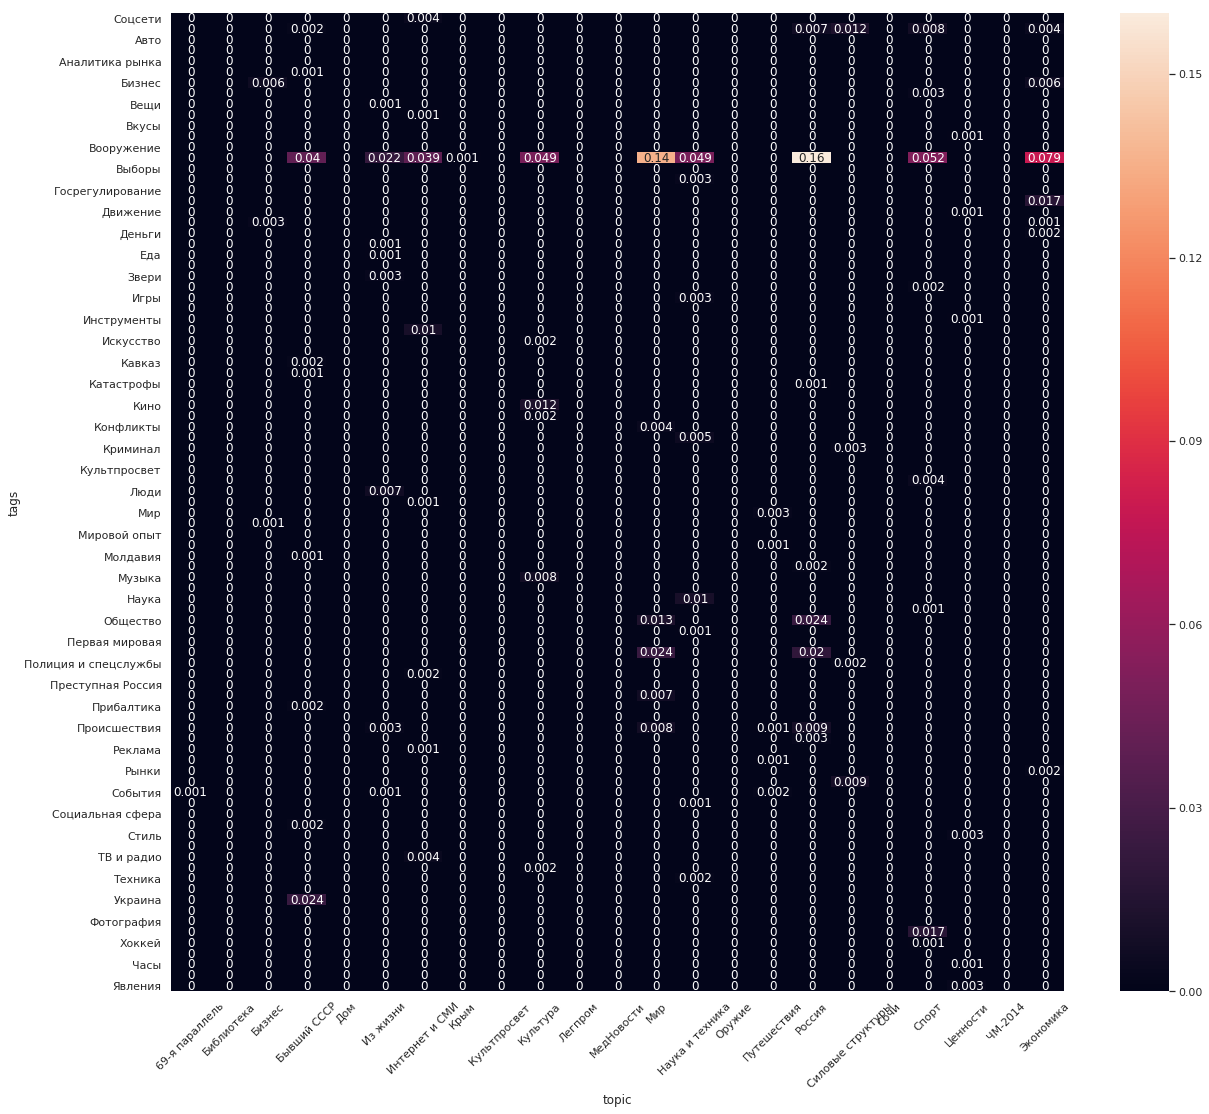

In [102]:
plt.figure(figsize=(20,18))
sns.heatmap(round(cmatrix, 3), annot=True)
plt.xticks(rotation=45);

In [103]:
df_sample = pd.merge(df_sample, cmatrix, on='tags')

In [104]:
df_sample.head()

,tags,text,title,topic,url,69-я параллель,Библиотека,Бизнес,Бывший СССР,Дом,...,Наука и техника,Оружие,Путешествия,Россия,Силовые структуры,Сочи,Спорт,Ценности,ЧМ-2014,Экономика
0,Общество,миллиардер илона маск резкий форма отвечать бр...,илона маск называть педофил спасать ребенок пе...,Мир,https://lenta.ru/news/2018/07/16/su57/,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.024223,0.0,0.0,0.0,0.0,0.0,0.0
1,Общество,большинство британский подданный выступать лег...,британец захотеть легализация марихуана,Мир,https://lenta.ru/news/2018/07/16/rosstat_podra...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.024223,0.0,0.0,0.0,0.0,0.0,0.0
2,Общество,следствие окончательно удостоверяться подлинно...,экспертиза подтверждать подлинность останки ца...,Россия,https://lenta.ru/news/2018/07/16/druzhba/,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.024223,0.0,0.0,0.0,0.0,0.0,0.0
3,Общество,пресс-секретарь патриарх московский весь русь ...,рпц объяснять происхождение частный самолет па...,Россия,https://lenta.ru/news/2018/07/15/schampur/,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.024223,0.0,0.0,0.0,0.0,0.0,0.0
4,Общество,шотландский полиция задерживать парапланерист ...,парапланерист пролететь голова трамп попадаться,Мир,https://lenta.ru/news/2018/07/15/goodbye_kommu...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.024223,0.0,0.0,0.0,0.0,0.0,0.0


In [105]:
topic_encoder = LabelEncoder()
all_targets = topic_encoder.fit_transform(df_sample['topic']) + 1

Let's find the numeric features and bring them to the desired VW format.

In [106]:
num_columns = df_sample.select_dtypes(include=[np.number]).columns

for col in tqdm_notebook(num_columns):
    df_sample[col] = df_sample[col].apply(lambda x: col + ':' + str(x))

In [107]:
df_sample.head()

,tags,text,title,topic,url,69-я параллель,Библиотека,Бизнес,Бывший СССР,Дом,...,Наука и техника,Оружие,Путешествия,Россия,Силовые структуры,Сочи,Спорт,Ценности,ЧМ-2014,Экономика
0,Общество,миллиардер илона маск резкий форма отвечать бр...,илона маск называть педофил спасать ребенок пе...,Мир,https://lenta.ru/news/2018/07/16/su57/,69-я параллель:0.0,Библиотека:0.0,Бизнес:0.0,Бывший СССР:0.0,Дом:0.0,...,Наука и техника:0.0,Оружие:0.0,Путешествия:0.0,Россия:0.02422307523015494,Силовые структуры:0.0,Сочи:0.0,Спорт:0.0,Ценности:0.0,ЧМ-2014:0.0,Экономика:0.0
1,Общество,большинство британский подданный выступать лег...,британец захотеть легализация марихуана,Мир,https://lenta.ru/news/2018/07/16/rosstat_podra...,69-я параллель:0.0,Библиотека:0.0,Бизнес:0.0,Бывший СССР:0.0,Дом:0.0,...,Наука и техника:0.0,Оружие:0.0,Путешествия:0.0,Россия:0.02422307523015494,Силовые структуры:0.0,Сочи:0.0,Спорт:0.0,Ценности:0.0,ЧМ-2014:0.0,Экономика:0.0
2,Общество,следствие окончательно удостоверяться подлинно...,экспертиза подтверждать подлинность останки ца...,Россия,https://lenta.ru/news/2018/07/16/druzhba/,69-я параллель:0.0,Библиотека:0.0,Бизнес:0.0,Бывший СССР:0.0,Дом:0.0,...,Наука и техника:0.0,Оружие:0.0,Путешествия:0.0,Россия:0.02422307523015494,Силовые структуры:0.0,Сочи:0.0,Спорт:0.0,Ценности:0.0,ЧМ-2014:0.0,Экономика:0.0
3,Общество,пресс-секретарь патриарх московский весь русь ...,рпц объяснять происхождение частный самолет па...,Россия,https://lenta.ru/news/2018/07/15/schampur/,69-я параллель:0.0,Библиотека:0.0,Бизнес:0.0,Бывший СССР:0.0,Дом:0.0,...,Наука и техника:0.0,Оружие:0.0,Путешествия:0.0,Россия:0.02422307523015494,Силовые структуры:0.0,Сочи:0.0,Спорт:0.0,Ценности:0.0,ЧМ-2014:0.0,Экономика:0.0
4,Общество,шотландский полиция задерживать парапланерист ...,парапланерист пролететь голова трамп попадаться,Мир,https://lenta.ru/news/2018/07/15/goodbye_kommu...,69-я параллель:0.0,Библиотека:0.0,Бизнес:0.0,Бывший СССР:0.0,Дом:0.0,...,Наука и техника:0.0,Оружие:0.0,Путешествия:0.0,Россия:0.02422307523015494,Силовые структуры:0.0,Сочи:0.0,Спорт:0.0,Ценности:0.0,ЧМ-2014:0.0,Экономика:0.0


In [108]:
train_news, test_news, train_targets, test_targets = \
    train_test_split(df_sample, all_targets, 
                     test_size=0.3, random_state=1)

In [111]:
with open('data/news/train.vw', 'w') as vw_train_data:
    for text, num, target in zip(train_news['text'], 
                                 train_news[num_columns].values, 
                                 train_targets):
        vw_train_data.write(to_vw_format(text, numeric=num, label=target))
        
with open('data/news/test.vw', 'w') as vw_test_data:
    for text, num in zip(test_news['text'], 
                         test_news[num_columns].values):
        vw_test_data.write(to_vw_format(text, numeric=num))

In [112]:
!vw --oaa 23 -d data/news/train.vw \
--loss_function logistic \
-f data/news/train_model.vw --quiet

In [113]:
!vw -i data/news/train_model.vw -t \
-d data/news/test.vw \
-p data/news/test_predictions.txt --quiet

In [114]:
with open('data/news/test_predictions.txt') as pred_file:
    test_prediction = [float(label) 
                             for label in pred_file.readlines()]

In [115]:
print('Accuracy: ' + str(round(accuracy_score(test_targets, test_prediction), 3)))

Accuracy: 0.829


The new features have slightly improve our score, so we can try to use them further.

Normalized confusion matrix


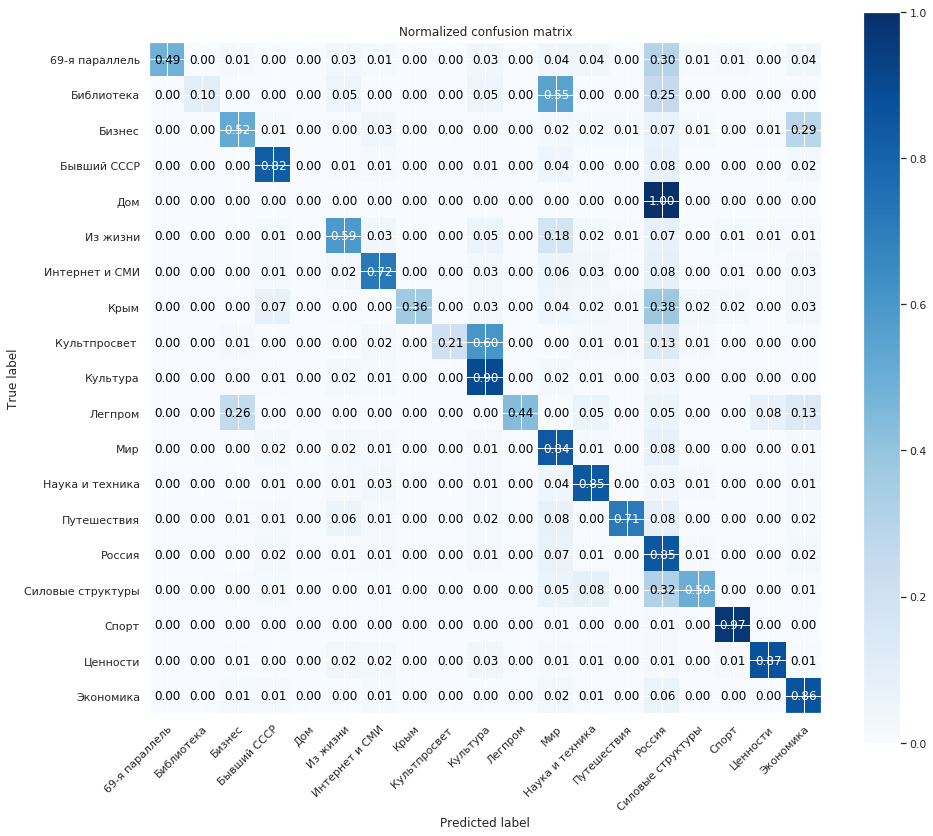

In [116]:
plot_confusion_matrix(test_targets, test_prediction, 
                      classes=np.arange(1, 24), normalize=True)

## Vowpal Wabbit with selected features

Divide the date into a year, month and week, and allocate the day of the week and if it was a weekend.

In [52]:
df_sample = df_preprocessed.copy()

cmatrix = pd.crosstab(df_sample['tags'], 
                      df_sample['topic'], 
                      normalize=True)

df_sample = pd.merge(df_sample, cmatrix, on='tags')

df_sample['url'] = pd.to_datetime(
                            df_sample['url'].apply(
                                lambda x: ('/').join(x.split('/')[4:7])))

df_sample['year'] = df_sample['url'].dt.year
df_sample['month'] = df_sample['url'].dt.month
df_sample['dayOfMonth'] = df_sample['url'].dt.day
df_sample['dayOfWeek'] = df_sample['url'].dt.dayofweek
df_sample['is_weekend'] = df_sample['dayOfWeek'].apply(
                            lambda x: 1 if x in (5, 6) else 0)

df_sample.drop(columns=['url'], inplace=True)

topic_encoder = LabelEncoder()
all_targets = topic_encoder.fit_transform(df_sample['topic']) + 1

num_columns = df_sample.select_dtypes(include=[np.number]).columns

We can deal with month and day of the month in different ways. If we use them as a real variable, we slightly contradict the nature of data: 1<31 while 01.02 > 31.01. At the same time, if we encode them as categorical variables, we'll breed a large numbers of features and lose information about proximity - the difference between 29 and 30 will be the same as the difference between 1 and 15. However, the difference between such coding methods is down to the third decimal place in the metric in our task.

In [53]:
for col in tqdm_notebook(num_columns):
    df_sample[col] = df_sample[col].apply(lambda x: col + ':' + str(x))

In [54]:
df_sample.head()

,tags,text,title,topic,69-я параллель,Библиотека,Бизнес,Бывший СССР,Дом,Из жизни,...,Сочи,Спорт,Ценности,ЧМ-2014,Экономика,year,month,dayOfMonth,dayOfWeek,is_weekend
0,Общество,миллиардер илона маск резкий форма отвечать бр...,илона маск называть педофил спасать ребенок пе...,Мир,69-я параллель:0.0,Библиотека:0.0,Бизнес:0.0,Бывший СССР:0.0,Дом:0.0,Из жизни:0.0,...,Сочи:0.0,Спорт:0.0,Ценности:0.0,ЧМ-2014:0.0,Экономика:0.0,year:2018,month:7,dayOfMonth:16,dayOfWeek:0,is_weekend:0
1,Общество,большинство британский подданный выступать лег...,британец захотеть легализация марихуана,Мир,69-я параллель:0.0,Библиотека:0.0,Бизнес:0.0,Бывший СССР:0.0,Дом:0.0,Из жизни:0.0,...,Сочи:0.0,Спорт:0.0,Ценности:0.0,ЧМ-2014:0.0,Экономика:0.0,year:2018,month:7,dayOfMonth:16,dayOfWeek:0,is_weekend:0
2,Общество,следствие окончательно удостоверяться подлинно...,экспертиза подтверждать подлинность останки ца...,Россия,69-я параллель:0.0,Библиотека:0.0,Бизнес:0.0,Бывший СССР:0.0,Дом:0.0,Из жизни:0.0,...,Сочи:0.0,Спорт:0.0,Ценности:0.0,ЧМ-2014:0.0,Экономика:0.0,year:2018,month:7,dayOfMonth:16,dayOfWeek:0,is_weekend:0
3,Общество,пресс-секретарь патриарх московский весь русь ...,рпц объяснять происхождение частный самолет па...,Россия,69-я параллель:0.0,Библиотека:0.0,Бизнес:0.0,Бывший СССР:0.0,Дом:0.0,Из жизни:0.0,...,Сочи:0.0,Спорт:0.0,Ценности:0.0,ЧМ-2014:0.0,Экономика:0.0,year:2018,month:7,dayOfMonth:15,dayOfWeek:6,is_weekend:1
4,Общество,шотландский полиция задерживать парапланерист ...,парапланерист пролететь голова трамп попадаться,Мир,69-я параллель:0.0,Библиотека:0.0,Бизнес:0.0,Бывший СССР:0.0,Дом:0.0,Из жизни:0.0,...,Сочи:0.0,Спорт:0.0,Ценности:0.0,ЧМ-2014:0.0,Экономика:0.0,year:2018,month:7,dayOfMonth:15,dayOfWeek:6,is_weekend:1


In [55]:
train_news, test_news, train_targets, test_targets = \
    train_test_split(df_sample, all_targets, 
                     test_size=0.3, random_state=1)

This time, in addition to the date, we also use tags distribution and a title.

In [56]:
with open('data/news/train.vw', 'w') as vw_train_data:
    for text, title, num, target in zip(train_news['text'],
                                        train_news['title'],
                                        train_news[num_columns].values,
                                        train_targets):
        vw_train_data.write(to_vw_format(text, title=title,
                                         numeric=num, label=target))

with open('data/news/test.vw', 'w') as vw_test_data:
    for text, title, num in zip(test_news['text'],
                                test_news['title'],
                                train_news[num_columns].values):
        vw_test_data.write(to_vw_format(text, title=title, numeric=num))

In [57]:
!vw --oaa 23 -d data/news/train.vw \
--loss_function logistic \
-f data/news/train_model.vw --quiet

In [58]:
!vw -i data/news/train_model.vw -t \
-d data/news/test.vw \
-p data/news/test_predictions.txt --quiet

In [59]:
with open('data/news/test_predictions.txt') as pred_file:
    test_prediction = [float(label) 
                             for label in pred_file.readlines()]

In [60]:
print('Accuracy: ' + str(round(accuracy_score(test_targets, test_prediction), 3)))

Accuracy: 0.826


The use of all features has slightly worsened the assessment. Let's try to use some of the features. Selecting different combinations of attributes has shown that the best combination is text, title and date.

In [26]:
with open('data/news/train.vw', 'w') as vw_train_data:
    for text, title, num, target in zip(train_news['text'],
                                        train_news['title'],
                                        train_news[num_columns].values,
                                        train_targets):
        vw_train_data.write(to_vw_format(text, title=title,
                                         numeric=num, label=target))

with open('data/news/test.vw', 'w') as vw_test_data:
    for text, title, num in zip(test_news['text'],
                                test_news['title'],
                                train_news[num_columns].values):
        vw_test_data.write(to_vw_format(text, title=title, numeric=num))

In [27]:
!vw --oaa 23 -d data/news/train.vw \
--loss_function logistic \
-f data/news/train_model.vw --quiet

In [28]:
!vw -i data/news/train_model.vw -t \
-d data/news/test.vw \
-p data/news/test_predictions.txt --quiet

In [29]:
with open('data/news/test_predictions.txt') as pred_file:
    test_prediction = [float(label)
                       for label in pred_file.readlines()]

In [30]:
print('Accuracy: ' + str(round(accuracy_score(test_targets, test_prediction), 3)))

Accuracy: 0.83


Normalized confusion matrix


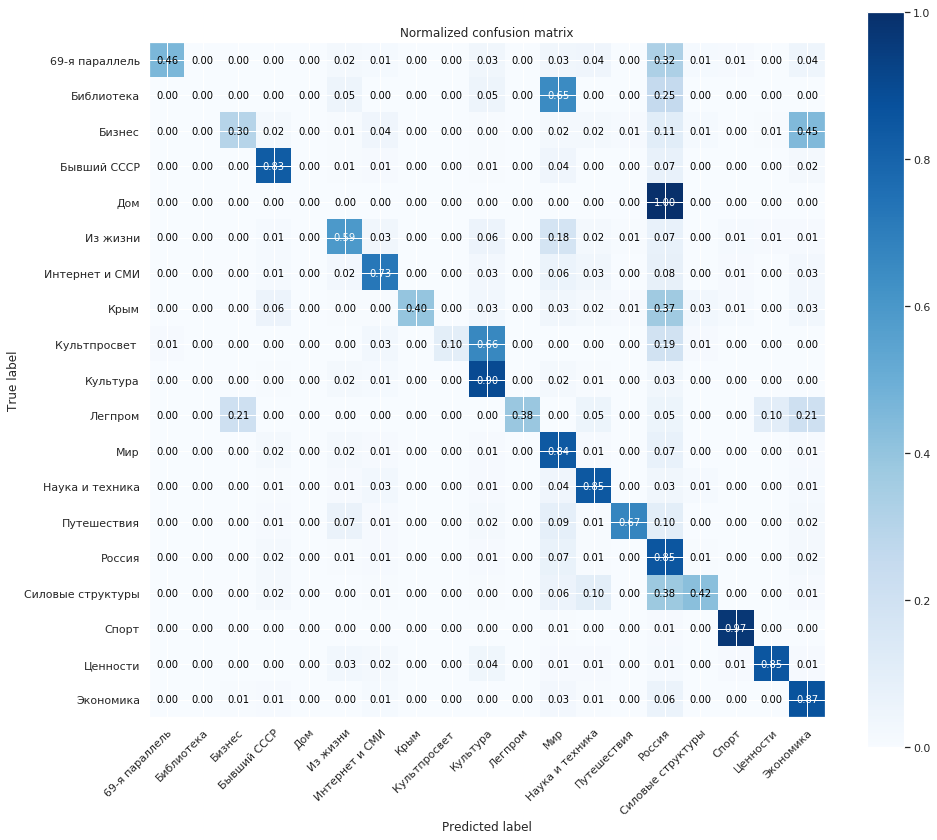

In [61]:
plot_confusion_matrix(test_targets, test_prediction, 
                      classes=np.arange(1, 24), normalize=True)

In [63]:
df_sample['topic'].value_counts()

Россия               158072
Мир                  134334
Экономика             77673
Спорт                 62463
Культура              52600
Бывший СССР           52018
Наука и техника       51869
Интернет и СМИ        43313
Из жизни              26356
Силовые структуры     18480
Бизнес                 7398
Ценности               6832
Путешествия            6045
69-я параллель         1095
Крым                    666
Культпросвет            340
Легпром                 114
Библиотека               65
Дом                       6
Оружие                    3
ЧМ-2014                   2
Сочи                      1
МедНовости                1
Name: topic, dtype: int64

We got the model's Accuracy at **0.83**.

As you can see from the confusion matrix, most of the errors occur in related categories, such as Economy and Business, Crimea and Russia, etc., because this news fits both these categories very well. There is also a high percentage of errors on the categories with very few elements - Library, Home, etc.

Also, we can see the high quality of the Vovpal Wabbit library out of the box - the basic model, taking into account only the text of the news showed a slightly worse result than the model with additional features and preprocessing of the text. 